<center><h2> Inpainting Sparse EPIs with Shearlets </h2></center>

In [1]:
using PyPlot
using Shearlab

In [2]:
n =512;

In [3]:
# The path of the sparse EPI
name_sparse = "../EPIs_Strips/EPIs/673_10_102_4_48_8_sparse.png";
EPI_sparse = Shearlab.load_image(name_sparse, n);
EPI_sparse = EPI_sparse[:,:,1];

In [4]:
m = size(EPI_sparse)[2]

690

In [5]:
name_dense = "../EPIs_Strips/EPIs/673_10_102_4_48_8_dense.png";
EPI_dense = Shearlab.load_image(name_dense, n,m);
EPI_dense = EPI_dense[:,:,1];

### Lets design the mask.

In [6]:
#Initialize with ones 
mask = ones(Float64,size(EPI_dense));

In [7]:
mask[abs.(EPI_dense-EPI_sparse).!=0]=0

0

In [8]:
for i in 1:size(EPI_sparse)[1]
    for 
    if abs.(sum(EPI_sparse[i,:])-sum(EPI_dense[i,:]))>=100
        mask[i,:] = 0;
    end
end

LoadError: syntax: invalid iteration specification

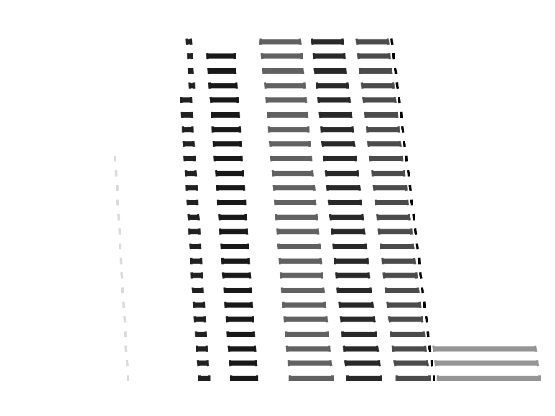

In [9]:
Shearlab.imageplot(EPI_sparse)

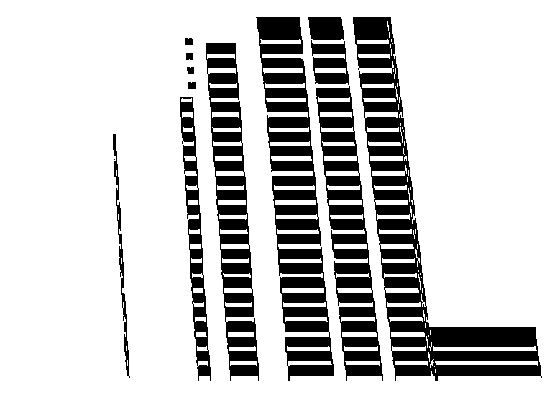

In [10]:
Shearlab.imageplot(mask)

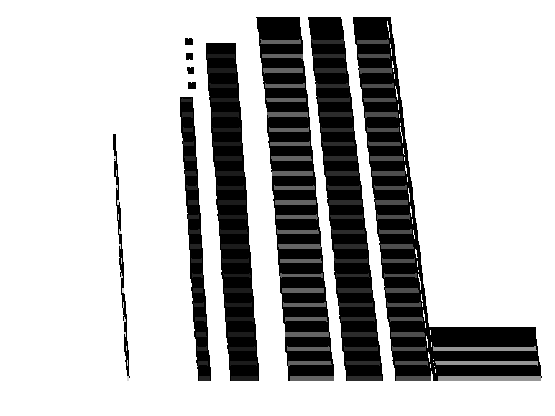

In [11]:
Shearlab.imageplot(EPI_sparse.*mask)

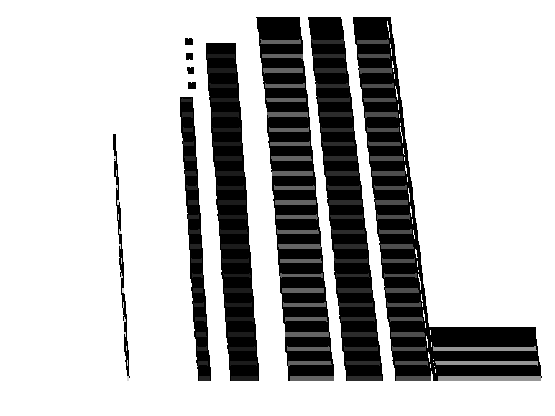

In [12]:
Shearlab.imageplot(EPI_dense.*mask)

### Inpainting

In [24]:
# Data 
EPI_masked = EPI_sparse.*mask;
stopFactor = 0.005; # The highest coefficient times stopFactor
sizeX = size(EPI_masked,1);
sizeY = size(EPI_masked,2);
nScales = 4;

In [25]:
tic()
shearletsystem = Shearlab.getshearletsystem2D(sizeX, sizeY, nScales);
toc()

elapsed time: 32.588347452 seconds


32.588347452

#### Normalized iterative thresholding

In [26]:
function inpaint2D(imgMasked,mask,iterations,stopFactor,shearletsystem)
    coeffs = Shearlab.sheardec2D(imgMasked,shearletsystem);
    coeffsNormalized = zeros(size(coeffs))+im*zeros(size(coeffs));
    for i in 1:shearletsystem.nShearlets
        coeffsNormalized[:,:,i] = coeffs[:,:,i]./shearletsystem.RMS[i];
    end
    delta = maximum(abs(coeffsNormalized[:]));
    lambda=(stopFactor)^(1/(iterations-1));
    imgInpainted = zeros(size(imgMasked));
    #iterative thresholding
    for it = 1:iterations
        res = mask.*(imgMasked-imgInpainted);
        coeffs = Shearlab.sheardec2D(imgInpainted+res,shearletsystem);
        coeffsNormalized = zeros(size(coeffs))+im*zeros(size(coeffs));
        for i in 1:shearletsystem.nShearlets
            coeffsNormalized[:,:,i] = coeffs[:,:,i]./shearletsystem.RMS[i];
        end
        coeffs = coeffs.*(abs(coeffsNormalized).>delta);
        imgInpainted = Shearlab.shearrec2D(coeffs,shearletsystem);  
        delta=delta*lambda;  
    end
    imgInpainted
end

inpaint2D (generic function with 1 method)

<b>Normalized iterative thresholding with varying velocity</b>.

In [ ]:
function inpaint2D(imgMasked,mask,iterations,stopFactor,shearletsystem)
    coeffs = Shearlab.sheardec2D(imgMasked,shearletsystem);
    coeffsNormalized = zeros(size(coeffs))+im*zeros(size(coeffs));
    for i in 1:shearletsystem.nShearlets
        coeffsNormalized[:,:,i] = coeffs[:,:,i]./shearletsystem.RMS[i];
    end
    delta = maximum(abs(coeffsNormalized[:]));
    lambda=(stopFactor)^(1/(iterations-1));
    imgInpainted = zeros(size(imgMasked));
    #iterative thresholding
    for it = 1:iterations
        res = mask.*(imgMasked-imgInpainted);
        coeffs = Shearlab.sheardec2D(imgInpainted+res,shearletsystem);
        coeffsNormalized = zeros(size(coeffs))+im*zeros(size(coeffs));
        for i in 1:shearletsystem.nShearlets
            coeffsNormalized[:,:,i] = coeffs[:,:,i]./shearletsystem.RMS[i];
        end
        coeffs = coeffs.*(abs(coeffsNormalized).>delta);
        imgInpainted = Shearlab.shearrec2D(coeffs,shearletsystem);  
        delta=delta*lambda;  
    end
    imgInpainted
end

### Iterations

In [27]:
tic()
EPIinpainted50 = inpaint2D(EPI_masked,mask,50,stopFactor,shearletsystem);
toc()

elapsed time: 279.691448463 seconds


279.691448463

In [28]:
tic()
EPIinpainted100 = inpaint2D(EPI_masked,mask,100,stopFactor,shearletsystem);
toc()

elapsed time: 585

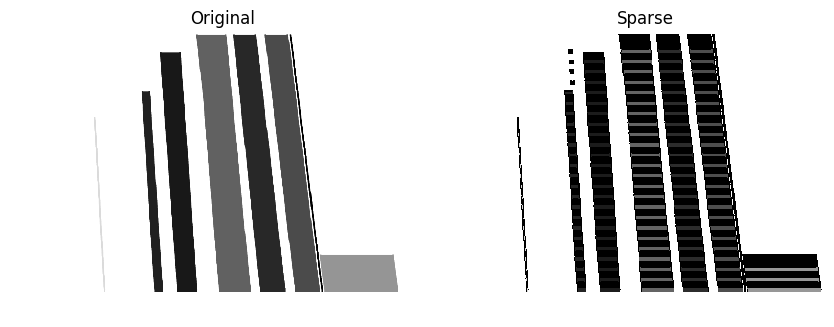

In [29]:
clf;
figure(figsize=(10,10));
Shearlab.imageplot(EPI_dense, "Original", 1,2,1); 
Shearlab.imageplot(EPI_masked, "Sparse", 1,2,2); 

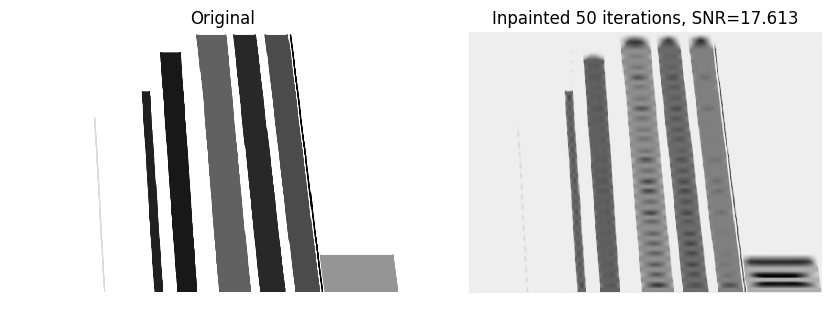

In [30]:
elin = Shearlab.snr(EPI_dense,EPIinpainted50);
# display
clf;
figure(figsize=(10,10));
Shearlab.imageplot(EPI_dense, "Original", 1,2,1); 
u = @sprintf("Inpainted 50 iterations, SNR=%.3f", elin);
Shearlab.imageplot(real(EPIinpainted50), u, 1,2,2);

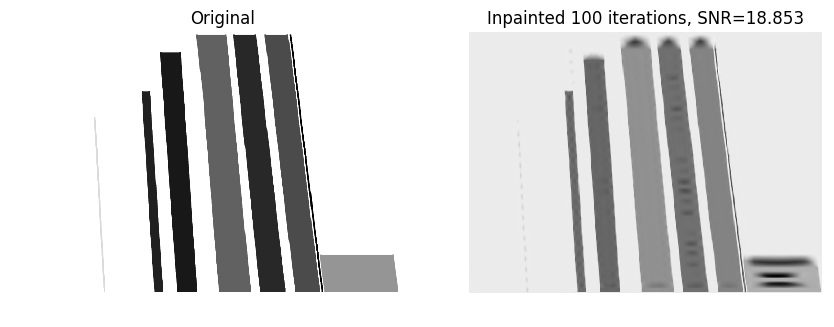

In [31]:
elin = Shearlab.snr(EPI_dense,EPIinpainted100);
# display
clf;
figure(figsize=(10,10));
Shearlab.imageplot(EPI_dense, "Original", 1,2,1); 
u = @sprintf("Inpainted 100 iterations, SNR=%.3f", elin);
Shearlab.imageplot(real(EPIinpainted100), u, 1,2,2);

##### Saving the inpainted image

In [110]:
name_inpainted1 = split(name_dense,"/")
name_inpainted1[3] = "Inpainted"
last_name = name_inpainted1[4]
last_name_split = split(last_name,"_")
last_name_split[7] = "inpainted.png"
last_name = last_name_split[1]
for i in 2:size(last_name_split)[1]
    last_name = last_name*"_"*last_name_split[i]
end
name_inpainted1[4] = last_name
name_inpainted = name_inpainted1[1]
for i in 2:size(name_inpainted1)[1]
    name_inpainted = name_inpainted*"/"*name_inpainted1[i]
end

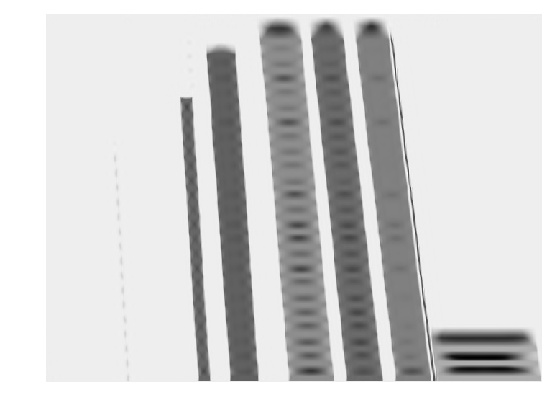

In [111]:
Shearlab.imageplot(real(EPIinpainted50))
savefig(name_inpainted, dpi = 80*3,bbox_inches="tight")